# Import libraries and modules

In [244]:
# Reload modules before executing user code
%load_ext autoreload
%autoreload 2

import os
import sys
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
from scipy.io import loadmat
import warnings
from contextlib import contextmanager
from copy import copy
from scipy.linalg import LinAlgWarning
from sklearn.exceptions import ConvergenceWarning

# Find current directory
current_dir = os.getcwd()
# Find root directory
root_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
# Add root directory to path
sys.path.append(root_dir)

print(f"Current directory: {current_dir}")
print(f"Root directory: {root_dir}")

import pysindy.pysindy as ps
from pysindy.differentiation import SmoothedFiniteDifference

# ignore user warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

np.random.seed(1000)  # Seed for reproducibility

# Integrator keywords for solve_ivp
integrator_keywords = {}
integrator_keywords['method'] = 'RK23'   #'LSODA'
integrator_keywords['rtol'] = 1.0  # 1e-3
integrator_keywords['atol'] = 1.0  # 1e-4
integrator_keywords['max_step'] = 0.1
integrator_keywords['h_factor'] = 1

system_size = 5
n_samples_train = 2000
n_samples_test = 500

poly_order = 2
threshold = 0
dt = 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Current directory: /u1/ame805/pysindy_fork/simlab_experiments
Root directory: /u1/ame805/pysindy_fork


# Functions

In [245]:
def readExpData(file_path, Nsize=100):
    
    if os.path.isfile(file_path):
        
        # extract data from file using numpy module
        data = np.loadtxt(file_path)
        size = np.shape(data)

        t_data = np.empty(shape=(size[0],))
        # first column of the file is time
        t_data[:] = data[:, 0]

        # remaining data is number of clusters of size n. Index for column i corresponds to number of clusters of size i-1
        # n_data = data[:, 1:Nsize+1]
        #** We just divide the cluster numbers by the volume of the system which is 126^3 (in units of sigma). 
        n_data = data[:, 1:Nsize+1] / (126**3)  ## only the first 'size' (excluding the very first 0) entries to match the kappa coeff
        
        return t_data, n_data
    
    else:
        print(f"Experiment file ({file_path}) does not exist")
        exit()

@contextmanager
def ignore_specific_warnings():
    filters = copy(warnings.filters)
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    warnings.filterwarnings("ignore", category=LinAlgWarning)
    warnings.filterwarnings("ignore", category=UserWarning)
    yield
    warnings.filters = filters

# Load data

In [246]:
experiment_dir = 'data'
experiment_file = 'Population_Training_Results.dat'
exp_dir = os.path.join(experiment_dir, experiment_file)

t_values, N_clusters = readExpData(exp_dir, Nsize=system_size)

# # n_samples_train random indices
# indices = np.random.choice(len(t_values), n_samples_train, replace=False)
# indices = np.sort(indices)
# Linearly spaced indices
indices = np.linspace(0, len(t_values)-1, n_samples_train, dtype=int)
N_clusters_train = N_clusters[indices]
t_values_train = t_values[indices]

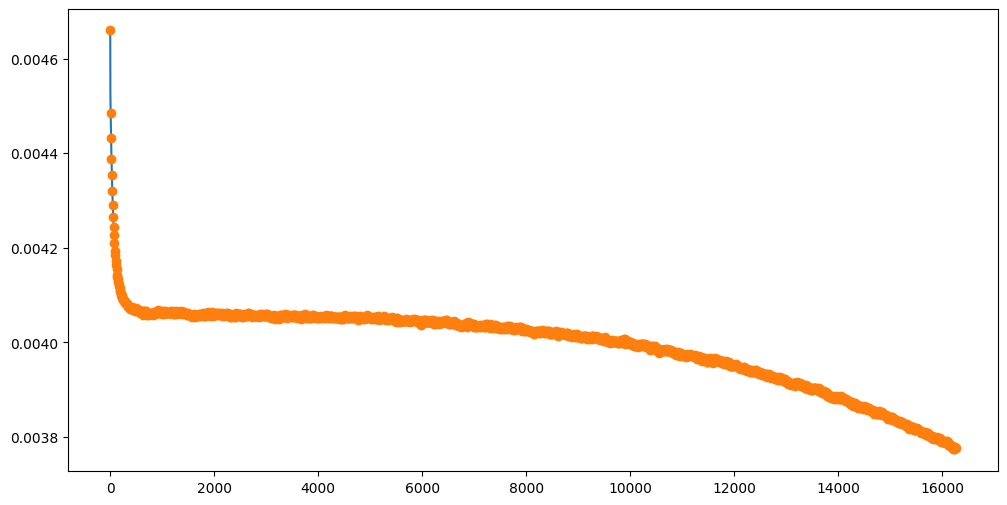

In [247]:
n_to_plot = 1

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(t_values, N_clusters[:, n_to_plot-1], label=f'Cluster size {n_to_plot}')
# plt.plot(t_values[:n_samples_train], N_clusters[:n_samples_train, n_to_plot-1], label=f'Cluster size {n_to_plot}')
plt.plot(t_values_train, N_clusters_train[:, n_to_plot-1], 'o', label=f'Training data Cluster size {n_to_plot}')

plt.show()

# Prepare the model (add constraints)

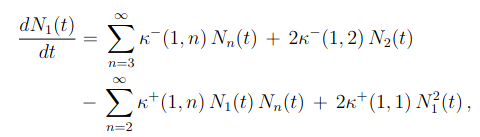

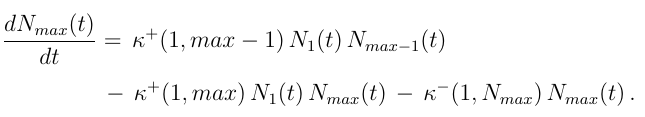

In [248]:
# Figure out how many library features there will be
library = ps.PolynomialLibrary()
library.fit([ps.AxesArray(N_clusters_train, {"ax_sample": 0, "ax_coord": 1})])
features_names = library.get_feature_names()
n_features = library.n_output_features_
print(f"Features ({n_features}):", features_names)

Features (21): ['1', 'x0', 'x1', 'x2', 'x3', 'x4', 'x0^2', 'x0 x1', 'x0 x2', 'x0 x3', 'x0 x4', 'x1^2', 'x1 x2', 'x1 x3', 'x1 x4', 'x2^2', 'x2 x3', 'x2 x4', 'x3^2', 'x3 x4', 'x4^2']


## Tests

In [249]:
# Repeat with inequality constraints, need CVXPY installed
try:
    import cvxpy  # noqa: F401

    run_cvxpy = True

    # eps = np.sqrt(np.finfo(float).eps)
    eps_value = 1e-6
    large_value = 1e6

    print('eps:', eps_value)
    print('large_value:', large_value)

except ImportError:
    run_cvxpy = False
    print("No CVXPY package is installed")

eps: 1e-06
large_value: 1000000.0


## Set up and 1st eq

In [250]:
#### Set constraints
# Number of clusters/equations
n_targets = N_clusters_train.shape[1]

print(f"Features ({n_features}):", features_names)

## Coefficients of quadratic terms are zero except for x0^2
# Find indices of quadratic terms excluding 'x0^2'
# # quadratic_idx_first = [i for i, feature_name in enumerate(features_names) if ('^2' in feature_name or feature_name.count('x') == 2) and 'x0' not in feature_name]
quadratic_idx_first = [i for i, feature_name in enumerate(features_names) \
                    if ('^2' in feature_name and 'x0' not in feature_name) \
                        or (feature_name.count('x') == 2 and 'x0' not in feature_name)]
n_quadratic_first = len(quadratic_idx_first)

# Initialize constraint_rhs and constraint_lhs for quadratic terms
constraint_rhs = np.full((2 * n_quadratic_first, ), eps_value)
constraint_lhs = np.zeros((2 * n_quadratic_first, n_targets * n_features))

# Set coefficients of each quadratic term (excluding 'x0^2') to be zero -> (>= -eps and <= eps)
for i, idx in enumerate(quadratic_idx_first):
    constraint_lhs[2 * i, idx] = 1
    constraint_lhs[2 * i + 1, idx] = -1

## Coefficients of quadratic terms are zero except for x0^2
# Find indices of quadratic terms excluding 'x0^2'
# # quadratic_idx_first = [i for i, feature_name in enumerate(features_names) if ('^2' in feature_name or feature_name.count('x') == 2) and 'x0' not in feature_name]
quadratic_idx_first = [i for i, feature_name in enumerate(features_names) \
                    if ('^2' in feature_name and 'x0' not in feature_name) \
                        or (feature_name.count('x') == 2 and 'x0' not in feature_name)]
n_quadratic_first = len(quadratic_idx_first)

# Initialize constraint_rhs and constraint_lhs for quadratic terms
constraint_rhs = np.append(constraint_rhs, np.full((2 * n_quadratic_first, ), eps_value))
constraint_lhs = np.vstack((constraint_lhs, np.zeros((2 * n_quadratic_first, n_targets * n_features))))

# Set coefficients of each quadratic term (excluding 'x0^2') to be zero -> (>= -eps and <= eps)
for i, idx in enumerate(quadratic_idx_first):
    constraint_lhs[-2 * n_quadratic_first + 2 * i, idx] = 1
    constraint_lhs[-2 * n_quadratic_first + 2 * i + 1, idx] = -1

## Coefficient of x0^2 is positive
# Find the index of the x0^2 term
x0sqs_idx = features_names.index('x0^2')
constraint_rhs = np.append(constraint_rhs, eps_value)
constraint_lhs = np.vstack((constraint_lhs, np.zeros((1, n_targets * n_features))))
constraint_lhs[-1, x0sqs_idx] = -1

## Coefficient of x0xN is negative
# Find the index of the x0xN term
x0xN_idx = [i for i, feature_name in enumerate(features_names) if ('x0' in feature_name) \
            and (feature_name.count('x')) == 2]
for idx in x0xN_idx:
    constraint_rhs = np.append(constraint_rhs, eps_value)
    constraint_lhs = np.vstack((constraint_lhs, np.zeros((1, n_targets * n_features))))
    constraint_lhs[-1, idx] = 1

## Coefficient of linear terms (except for 0) are positive
# Find the indices of linear terms (excluding 'x0')
linear_idx = [i for i, feature_name in enumerate(features_names) if ('x0' not in feature_name) \
              and (feature_name.count('x')) == 1]
for idx in linear_idx:
    constraint_rhs = np.append(constraint_rhs, eps_value)
    constraint_lhs = np.vstack((constraint_lhs, np.zeros((1, n_targets * n_features))))
    constraint_lhs[-1, idx] = -1

## Coefficient of x0 is zero
constraint_rhs = np.append(constraint_rhs, [eps_value, eps_value])
constraint_lhs = np.vstack((constraint_lhs, np.zeros((2, n_targets * n_features))))
x0_idx = features_names.index('x0')
constraint_lhs[-2, x0_idx] = 1
constraint_lhs[-1, x0_idx] = -1

## Constant term is zero -> (>= -eps and <= eps)
# Find the index of the constant term '1'
constant_term_idx = features_names.index('1')
constraint_rhs = np.append(constraint_rhs, [eps_value, eps_value])
constraint_lhs = np.vstack((constraint_lhs, np.zeros((2, n_targets * n_features))))
constraint_lhs[-2, constant_term_idx] = 1
constraint_lhs[-1, constant_term_idx] = -1

## Ensure x0^2 coefficient is positive
# x0^2 >= eps
constraint_rhs = np.append(constraint_rhs, eps_value)
constraint_lhs = np.vstack((constraint_lhs, np.zeros((1, n_targets * n_features))))
x0sqs_idx = features_names.index('x0^2')
constraint_lhs[-1, x0sqs_idx] = -1

Features (21): ['1', 'x0', 'x1', 'x2', 'x3', 'x4', 'x0^2', 'x0 x1', 'x0 x2', 'x0 x3', 'x0 x4', 'x1^2', 'x1 x2', 'x1 x3', 'x1 x4', 'x2^2', 'x2 x3', 'x2 x4', 'x3^2', 'x3 x4', 'x4^2']


## Eq 2 to N-1

In [251]:
print(f"Features ({n_features}):", features_names)

### Add constraints for the middle cluster sizes (Eq 2 to N-1)
for eq in range(1, n_targets - 1):
    ## All linear terms except for xN and xN+1  to be zero -> (>= -eps and <= eps)
    # Find the indices of linear terms excluding 'xN' and 'xN+1'
    linear_idx = [i for i, feature_name in enumerate(features_names) if 
                      (feature_name.count('x') == 1 and f'x{eq}' != feature_name and f'x{eq + 1}' != feature_name) 
                      and '^' not in feature_name]

    n_linear = len(linear_idx)

    # Append to constraint_rhs and constraint_lhs
    last_row = constraint_lhs.shape[0]
    constraint_rhs = np.append(constraint_rhs, [eps_value] * 2 * n_linear)
    constraint_lhs = np.vstack((constraint_lhs, np.zeros((2 * n_linear, n_targets * n_features))))

    # Set coefficients of each linear term (excluding 'xN' and 'xN+1') to be zero -> (>= -eps and <= eps)
    for i, idx in enumerate(linear_idx):
        constraint_lhs[2 * i + last_row, eq * n_features + idx] = 1
        constraint_lhs[2 * i + 1 + last_row, eq * n_features + idx] = -1

    ## Coefficient of xN is negative
    # Find the index of the xN term
    xN_idx = features_names.index(f'x{eq}')
    constraint_rhs = np.append(constraint_rhs, eps_value)
    constraint_lhs = np.vstack((constraint_lhs, np.zeros((1, n_targets * n_features))))
    constraint_lhs[-1, eq * n_features + xN_idx] = 1

    if eq > 1:
        ## Coefficient of xN is in Eq eq and Eq1 are to be negatives of one another 
        constraint_rhs = np.append(constraint_rhs, [eps_value, eps_value])
        constraint_lhs = np.vstack((constraint_lhs, np.zeros((2, n_targets * n_features))))
        constraint_lhs[-2, eq * n_features + xN_idx] = 1
        constraint_lhs[-2, xN_idx] = 1
        constraint_lhs[-1, eq * n_features + xN_idx] = -1
        constraint_lhs[-1, xN_idx] = -1
    else:
        ## Coefficient of xN is in Eq eq is to be half the value of Eq 1
        constraint_rhs = np.append(constraint_rhs, [eps_value, eps_value])
        constraint_lhs = np.vstack((constraint_lhs, np.zeros((1, n_targets * n_features))))
        constraint_lhs[-2, eq * n_features + xN_idx] = 1
        constraint_lhs[-2, xN_idx] = 0.5
        constraint_lhs[-1, eq * n_features + xN_idx] = -1
        constraint_lhs[-1, xN_idx] = -0.5

    ## Coefficient of xN+1 is positive
    # Find the index of the xN+1 term
    xN1_idx = features_names.index(f'x{eq + 1}')
    constraint_rhs = np.append(constraint_rhs, eps_value)
    constraint_lhs = np.vstack((constraint_lhs, np.zeros((1, n_targets * n_features))))
    constraint_lhs[-1, eq * n_features + xN1_idx] = -1

    ## Coefficient of xN+1 is in Eq eq and Eq1 are to be equal
    constraint_rhs = np.append(constraint_rhs, [eps_value, eps_value])
    constraint_lhs = np.vstack((constraint_lhs, np.zeros((2, n_targets * n_features))))
    constraint_lhs[-2, eq * n_features + xN1_idx] = 1
    constraint_lhs[-2, xN1_idx] = -1
    constraint_lhs[-1, eq * n_features + xN1_idx] = -1
    constraint_lhs[-1, xN1_idx] = 1

    ## Constant term is zero -> (>= -eps and <= eps)
    # Find the index of the constant term '1'
    constant_term_idx = features_names.index('1')
    constraint_rhs = np.append(constraint_rhs, [eps_value, eps_value])
    constraint_lhs = np.vstack((constraint_lhs, np.zeros((2, n_targets * n_features))))
    constraint_lhs[-2, eq * n_features + constant_term_idx] = 1
    constraint_lhs[-1, eq * n_features + constant_term_idx] = -1

    ## All quadratic terms except for x0 xN and x0 xN-1 (including x0^2) to be zero -> (>= -eps and <= eps)
    # Find indices of quadratic terms excluding 'x0 xN' and 'x0 xN-1'
    quadratic_idx_mix = [i for i, feature_name in enumerate(features_names) if 
                            ((feature_name.count('x') == 2 and f'x0 x{eq}' != feature_name and f'x0 x{eq - 1}' != feature_name) 
                            or ('^2' in feature_name and 'x0' not in feature_name))
                            or ('x0^2' in feature_name and eq != 1)]
    n_quadratic_mix = len(quadratic_idx_mix)

    # Add constraints for quadratic terms
    last_row = constraint_lhs.shape[0]
    constraint_rhs = np.append(constraint_rhs, [eps_value] * 2 * n_quadratic_mix)
    constraint_lhs = np.vstack((constraint_lhs, np.zeros((2 * n_quadratic_mix, n_targets * n_features))))

    for i, idx in enumerate(quadratic_idx_mix):
        constraint_lhs[2 * i + last_row, eq * n_features + idx] = 1
        constraint_lhs[2 * i + 1 + last_row, eq * n_features + idx] = -1

    ## Coefficient of x0 xN is negative
    # Find the index of the x0 xN term
    x0xN_idx = [i for i, feature_name in enumerate(features_names) if ('x0' in feature_name) and (f'x0 x{eq}' in feature_name)]
    for idx in x0xN_idx:
        constraint_rhs = np.append(constraint_rhs, eps_value)
        constraint_lhs = np.vstack((constraint_lhs, np.zeros((1, n_targets * n_features))))
        constraint_lhs[-1, eq * n_features + idx] = 1

    ## Coefficient of x0 xN-1 is positive
    # Find the index of the x0 xN-1 term
    x0xN1_idx = [i for i, feature_name in enumerate(features_names) if 
                 ('x0^2' in feature_name) or (f'x0 x{eq - 1}' in feature_name)]
    for idx in x0xN1_idx:
        constraint_rhs = np.append(constraint_rhs, eps_value)
        constraint_lhs = np.vstack((constraint_lhs, np.zeros((1, n_targets * n_features))))
        constraint_lhs[-1, eq * n_features + idx] = -1

    

Features (21): ['1', 'x0', 'x1', 'x2', 'x3', 'x4', 'x0^2', 'x0 x1', 'x0 x2', 'x0 x3', 'x0 x4', 'x1^2', 'x1 x2', 'x1 x3', 'x1 x4', 'x2^2', 'x2 x3', 'x2 x4', 'x3^2', 'x3 x4', 'x4^2']


In [252]:
[features_names[i] for i in linear_idx]

['x0', 'x1', 'x2']

## Last equation

In [253]:
### Add constraints for the last cluster size (Eq N)
## All linear terms to be zero except for xN
linear_idx_last = [i for i, feature_name in enumerate(features_names) if feature_name.count('x') == 1 
                  and '^' not in feature_name 
                  and f'x{n_targets - 1}' not in feature_name]
n_linear = len(linear_idx_last)

last_row = constraint_lhs.shape[0]
# Set coefficients of each linear term (excluding 'xN') to be zero -> (>= -eps and <= eps)
constraint_rhs = np.append(constraint_rhs, [eps_value] * 2 * n_linear)
constraint_lhs = np.vstack((constraint_lhs, np.zeros((2 * n_linear, n_targets * n_features))))

for i, idx in enumerate(linear_idx_last):
    constraint_lhs[2 * i + last_row, (n_targets - 1) * n_features + idx] = 1
    constraint_lhs[2 * i + 1 + last_row, (n_targets - 1) * n_features + idx] = -1

## Coeff of xN to be negative
# Find the index of the xN term
xN_idx = features_names.index(f'x{n_targets - 1}')
constraint_rhs = np.append(constraint_rhs, -eps_value)
constraint_lhs = np.vstack((constraint_lhs, np.zeros((1, n_targets * n_features))))
constraint_lhs[-1, (n_targets - 1) * n_features + xN_idx] = 1

## Coefficient of xN is in Eq eq and Eq1 are to be negatives of one another 
constraint_rhs = np.append(constraint_rhs, [eps_value, eps_value])
constraint_lhs = np.vstack((constraint_lhs, np.zeros((2, n_targets * n_features))))
constraint_lhs[-2, (n_targets - 1) * n_features + xN_idx] = 1
constraint_lhs[-2, xN_idx] = 1

last_row = constraint_lhs.shape[0]
## All quadratic terms to be zero except for x0 xN and x0 xN-1
quadratic_idx_last = [i for i, feature_name in enumerate(features_names) if 
                      ((feature_name.count('x') == 2) and (f'x0 x{n_targets - 1}' not in feature_name 
                       and f'x0 x{n_targets - 2}' not in feature_name)) 
                      or '^2' in feature_name]
n_quadratic_last = len(quadratic_idx_last)

# Set coefficients of each quadratic term (excluding 'x0 xN' and 'x0 xN-1') to be zero -> (>= -eps and <= eps)
constraint_rhs = np.append(constraint_rhs, [eps_value] * 2 * n_quadratic_last)
constraint_lhs = np.vstack((constraint_lhs, np.zeros((2 * n_quadratic_last, n_targets * n_features))))

for i, idx in enumerate(quadratic_idx_last):
    constraint_lhs[2 * i + last_row, (n_targets - 1) * n_features + idx] = 1
    constraint_lhs[2 * i + 1 + last_row, (n_targets - 1) * n_features + idx] = -1

## Constant term is zero -> (>= -eps and <= eps)
# Find the index of the constant term '1'
constant_term_idx = features_names.index('1')
constraint_rhs = np.append(constraint_rhs, [eps_value, eps_value])
constraint_lhs = np.vstack((constraint_lhs, np.zeros((2, n_targets * n_features))))
constraint_lhs[-2, (n_targets - 1) * n_features + constant_term_idx] = 1
constraint_lhs[-1, (n_targets - 1) * n_features + constant_term_idx] = -1

## Coeff of x0 xN to be negative
# Find the index of the x0 xN term
x0xN_idx = features_names.index(f'x0 x{n_targets - 1}')
constraint_rhs = np.append(constraint_rhs, -eps_value)
constraint_lhs = np.vstack((constraint_lhs, np.zeros((1, n_targets * n_features))))
constraint_lhs[-1, (n_targets - 1) * n_features + x0xN_idx] = 1

## Coeff of x0 xN-1 to be positive
# Find the index of the x0 xN-1 term
x0xN_idx = features_names.index(f'x0 x{n_targets - 2}')
constraint_rhs = np.append(constraint_rhs, eps_value)
constraint_lhs = np.vstack((constraint_lhs, np.zeros((1, n_targets * n_features))))
constraint_lhs[-1, (n_targets - 1) * n_features + x0xN_idx] = -1

In [254]:
# [features_names[i] for i in quadratic_idx_last]

# Build and fit the model

In [255]:
# # Repeat with inequality constraints
# # constraint_rhs = np.array([2, 2, large_value, eps_value])
# constraint_rhs = np.array([eps_value, eps_value, -5.5, 6])

# # One row per constraint, one column per coefficient
# constraint_lhs = np.zeros((constraint_rhs.shape[0], n_targets * n_features))

# # 1 * (x0 coefficient) + 1 * (x1 coefficient) <= eps
# constraint_lhs[0, 1] = 1
# constraint_lhs[0, 2] = -1

# # -eps <= 1 * (x0 coefficient) + 1 * (x1 coefficient)
# constraint_lhs[1, 1] = -1
# constraint_lhs[1, 2] = 1

# # 1 * (x0 coefficient) <= -5.5
# constraint_lhs[2, 6] = 1

# # -6 <= 1 * (x0 coefficient)
# constraint_lhs[3, 6] = -1

In [256]:
smoothed_fd = SmoothedFiniteDifference(smoother_kws={'window_length': 5})
differentiation_method = smoothed_fd

optimizer = ps.ConstrainedSR3(
    verbose=True,
    constraint_rhs=constraint_rhs,
    constraint_lhs=constraint_lhs,
    inequality_constraints=True,  # Ensure this is True for inequality constraints
    thresholder="l2",
    tol=1e-7,
    threshold=1e-12,
    max_iter=100000,
)

feature_library = ps.PolynomialLibrary(degree=poly_order)

with ignore_specific_warnings():
    # Fit the model
    model = ps.SINDy( 
        # discrete_time=True,
        differentiation_method=differentiation_method,
        optimizer=optimizer,
        feature_library=feature_library,
    )
    model.fit(N_clusters_train, t=dt)

# Print the model
model.print(precision=4)

model.save('.', precision=4)

 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y - Xw|^2 + |w - u|^2 / v + R(u)


/u1/ame805/pysindy_fork/venv-pysindy/lib/python3.12/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


         0 ... 2.9003e-09 ... 2.2820e+11 ... 2.2820e-13 ... 2.2820e+11
(x0)' = 0.0206 x1 + 0.2013 x2 + 0.2887 x3 + 0.5467 x4 + 0.0348 x0^2 + -17.0192 x0 x1 + -8.1566 x0 x2 + -6.9865 x0 x3 + -6.7344 x0 x4
(x1)' = -0.0103 x1 + 0.2013 x2 + 0.3079 x0^2 + -9.5334 x0 x1
(x2)' = -0.2013 x2 + 0.2887 x3 + 6.4251 x0 x1 + -6.6582 x0 x2
(x3)' = -0.2887 x3 + 0.5467 x4 + 6.7434 x0 x2 + -6.5918 x0 x3
(x4)' = -0.0992 x4 + 6.7391 x0 x3 + -6.5849 x0 x4


In [257]:
print(f"Features ({n_features}):", features_names)

Features (21): ['1', 'x0', 'x1', 'x2', 'x3', 'x4', 'x0^2', 'x0 x1', 'x0 x2', 'x0 x3', 'x0 x4', 'x1^2', 'x1 x2', 'x1 x3', 'x1 x4', 'x2^2', 'x2 x3', 'x2 x4', 'x3^2', 'x3 x4', 'x4^2']
